# **Predicting monthly revenue on 2026 data w/ base price & dynamic price**

As a preface to this code and what it does:

**All necessary files should be found in the folder called "forPredictions/"**

This model will need **5** different csv files:
- parkingdata_streamlined.csv
- monthlyParkingRevenue.csv
- basePrice.csv
- 2026predictedparkingdata_streamlined.csv
- dynamicModelSheet.csv

---
This model will first learn on the historic data (parkingdata_streamlined.csv ; monthlyParkingRevenue.csv). It will also learn using the price table set that can be set easily. In the learning phase, it will use the basePrice.csv to order to train and test.

---
In the next phase, it will use the trained and tested random forest model and have it predict on the 2026 data. It will output the predicted monthly revenue using the base prices.

---
In the last phase, it will use the model again on the 2026 data, but this time it will use the dynamic pricing table instead. It will output the predicted monthly revenue if we used the dynamic pricing model in 2026.

There will be 3 different outputs that represent each phase:
- predictedMonthlyRevenue_historical.csv
- predictedMonthlyRevenue_2026standard.csv
- predictedMonthlyRevenue_2026dynamic.csv

In [ ]:
# Requires: pandas, numpy, scikit-learn
# pip install pandas numpy scikit-learn

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

# -----------------------
# Config / filenames
# -----------------------
OCC_FILE = "parkingdata_streamlined.csv"
MONTHLY_REV_FILE = "monthlyParkingRevenue.csv"
BASE_PRICE_FILE = "basePrice.csv"
OUTPUT_PRED_CSV = "predictedMonthlyRevenue_historical.csv"

# New prediction config
FUTURE_OCC_FILE = "2026predictedparkingdata_streamlined.csv"
FUTURE_OUTPUT_PRED_CSV = "predictedMonthlyRevenue_2026standard.csv"

# For dynamic pricing scenario
DYNAMIC_PRICE_FILE = "newDynamicPriceTable.csv"
DYNAMIC_OUTPUT_PRED_CSV = "predictedMonthlyRevenue_2026dynamic.csv"


RANDOM_SEED = 42
TEST_SIZE = 0.2

LOTS = [
    ("lot2", "LOT 2 General", "LOT 2 Premium"),
    ("lot3", "LOT 3", None),
    ("lot4", "LOT 4 General", "LOT 4 Premium"),
    ("lot5", "LOT 5", None),
    ("lot6", "LOT 6", None),
]

# -----------------------
# Utility functions
# -----------------------
def load_data(occ_file=OCC_FILE, monthly_file=MONTHLY_REV_FILE, price_file=BASE_PRICE_FILE):
    occ = pd.read_csv(occ_file)
    monthly = pd.read_csv(monthly_file)
    price = pd.read_csv(price_file)
    return occ, monthly, price

def preprocess_occupancy_df(occ):
    occ = occ.copy()
    occ['Date'] = pd.to_datetime(occ['Date'])
    occ['year'] = occ['Date'].dt.year
    occ['month'] = occ['Date'].dt.month
    occ = occ[occ['year'] != 2024]
    occ_cols = [c for c in occ.columns if ('Occupied' in c) or ('% Capacity' in c)]
    occ[occ_cols] = occ[occ_cols].replace({0: np.nan, -1: np.nan})
    return occ

def build_daily_price_matrix(occ, price_df):
    occ = occ.copy()
    if 'UtilizationRate' not in price_df.columns:
        raise ValueError("basePrice.csv must have a column called 'UtilizationRate'")
    util_rates = price_df['UtilizationRate'].astype(float).values
    sort_idx = np.argsort(util_rates)
    util_rates = util_rates[sort_idx]
    price_df_cols = {c.lower(): c for c in price_df.columns}
    for shortname, general_pref, premium_pref in LOTS:
        # General
        if general_pref:
            util_col = f"{general_pref} % Capacity"
            occ_col = f"{general_pref} Occupied" if f"{general_pref} Occupied" in occ.columns else None
            spaces_col = f"{general_pref} Spaces" if f"{general_pref} Spaces" in occ.columns else None
            ux = None
            if util_col in occ.columns:
                ux = occ[util_col].astype(float)
            elif occ_col and spaces_col:
                ux = occ[occ_col].astype(float) / occ[spaces_col].astype(float)
            if ux is not None:
                price_col_name = None
                candidate = (shortname + "General").lower()
                for c_lower, c_orig in price_df_cols.items():
                    if candidate in c_lower or shortname in c_lower:
                        if 'general' in c_lower or ('premium' not in c_lower and 'general' not in c_lower):
                            price_col_name = c_orig
                exact_gen = f"{shortname}general"
                for c_lower, c_orig in price_df_cols.items():
                    if exact_gen in c_lower:
                        price_col_name = c_orig
                        break
                if price_col_name is None:
                    numeric_cols = [c for c in price_df.columns if c != 'UtilizationRate']
                    price_col_name = numeric_cols[0]
                price_vals = price_df[price_col_name].astype(float).values[sort_idx]
                daily_price_col = f"{shortname}_general_price"
                occ[daily_price_col] = np.interp(ux.fillna(0).values, util_rates, price_vals)
                if occ_col:
                    occ[f"{shortname}_general_est_revenue"] = occ[daily_price_col] * occ[occ_col].astype(float)
        # Premium
        if premium_pref:
            util_col = f"{premium_pref} % Capacity"
            occ_col = f"{premium_pref} Occupied" if f"{premium_pref} Occupied" in occ.columns else None
            spaces_col = f"{premium_pref} Spaces" if f"{premium_pref} Spaces" in occ.columns else None
            ux = None
            if util_col in occ.columns:
                ux = occ[util_col].astype(float)
            elif occ_col and spaces_col:
                ux = occ[occ_col].astype(float) / occ[spaces_col].astype(float)
            if ux is not None:
                price_col_name = None
                candidate = (shortname + "Premium").lower()
                for c_lower, c_orig in price_df_cols.items():
                    if candidate in c_lower or shortname in c_lower:
                        price_col_name = c_orig
                exact_prem = f"{shortname}premium"
                for c_lower, c_orig in price_df_cols.items():
                    if exact_prem in c_lower:
                        price_col_name = c_orig
                        break
                if price_col_name is None:
                    numeric_cols = [c for c in price_df.columns if c != 'UtilizationRate']
                    price_col_name = numeric_cols[0]
                price_vals = price_df[price_col_name].astype(float).values[sort_idx]
                daily_price_col = f"{shortname}_premium_price"
                occ[daily_price_col] = np.interp(ux.fillna(0).values, util_rates, price_vals)
                if occ_col:
                    occ[f"{shortname}_premium_est_revenue"] = occ[daily_price_col] * occ[occ_col].astype(float)
    return occ

def aggregate_monthly_features(occ_with_prices):
    df = occ_with_prices.copy()
    features = []
    for (y, m), grp in df.groupby(['year','month']):
        feat = {'year': int(y), 'month': int(m)}
        for shortname, general_pref, premium_pref in LOTS:
            util_cols = [c for c in grp.columns if ("% Capacity" in c) and (shortname.replace("lot","LOT ").lower() in c.lower())]
            if util_cols:
                util = grp[util_cols[0]].dropna()
                feat[f"{shortname}_avg_util"] = util.mean() if not util.empty else np.nan
                feat[f"{shortname}_std_util"] = util.std() if not util.empty else np.nan
            else:
                feat[f"{shortname}_avg_util"] = np.nan
                feat[f"{shortname}_std_util"] = np.nan
            gen_price_col = f"{shortname}_general_price"
            prem_price_col = f"{shortname}_premium_price"
            feat[f"{shortname}_avg_price_general"] = grp[gen_price_col].mean() if gen_price_col in grp else np.nan
            feat[f"{shortname}_avg_price_premium"] = grp[prem_price_col].mean() if prem_price_col in grp else np.nan
            est_rev_cols = [c for c in grp.columns if (f"{shortname}_" in c) and ("est_revenue" in c)]
            feat[f"{shortname}_sum_est_revenue"] = grp[est_rev_cols].sum(axis=0).sum() if est_rev_cols else np.nan
        est_rev_cols_all = [c for c in grp.columns if "est_revenue" in c]
        feat['total_estimated_revenue_all_lots'] = grp[est_rev_cols_all].sum(axis=0).sum() if est_rev_cols_all else np.nan
        features.append(feat)
    feat_df = pd.DataFrame(features).sort_values(['year','month']).reset_index(drop=True)
    return feat_df

def prepare_labels(monthly_df):
    df = monthly_df.copy()
    revenue_col = None
    for c in df.columns:
        if c.lower() in ('revenue','total_revenue','rev'):
            revenue_col = c
            break
    if not revenue_col:
        revenue_col = df.columns[-1]
    df = df.rename(columns={revenue_col:'revenue'})
    df['year'] = df['year'].astype(int)
    if df['month'].dtype == object:
        try:
            df['month'] = pd.to_datetime(df['month'], format='%B').dt.month
        except Exception:
            df['month'] = pd.to_datetime(df['month']).dt.month
    df['revenue'] = df['revenue'].astype(float)
    return df[['year','month','revenue']]

def create_train_test_split(feature_df, labels_df, test_size=TEST_SIZE, random_state=RANDOM_SEED):
    merged = pd.merge(feature_df, labels_df, on=['year','month'], how='inner')
    month_ids = merged[['year','month']].drop_duplicates().reset_index(drop=True)
    train_idx, test_idx = train_test_split(month_ids.index.values, test_size=test_size, random_state=random_state)
    train_months = month_ids.loc[train_idx]
    test_months = month_ids.loc[test_idx]
    train_df = merged.merge(train_months, on=['year','month'], how='inner')
    test_df = merged.merge(test_months, on=['year','month'], how='inner')
    return train_df, test_df, merged

def train_and_evaluate(train_df, test_df, feature_columns=None, random_state=RANDOM_SEED):
    exclude = {'year','month','revenue'}
    if feature_columns is None:
        feature_columns = [c for c in train_df.columns if np.issubdtype(train_df[c].dtype, np.number) and c not in exclude]
    X_train, y_train = train_df[feature_columns].fillna(0), train_df['revenue']
    X_test, y_test = test_df[feature_columns].fillna(0), test_df['revenue']
    model = RandomForestRegressor(n_estimators=200, random_state=random_state, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae, rmse = mean_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred)**0.5
    print(f"Test MAE: {mae:,.2f}")
    print(f"Test RMSE: {rmse:,.2f}")
    return model, feature_columns, mae, rmse

def predict_all_months(feature_df, model, feature_columns):
    df = feature_df.copy()
    preds = model.predict(df[feature_columns].fillna(0))
    df['predictedRevenue'] = np.round(preds, 2)
    return df[['year','month','predictedRevenue']]

# -----------------------
# Future prediction function
# -----------------------
def predict_future_revenue(model, feature_columns, occ_path, price_path, output_path):
    print("\n=== Predicting Future (2026) Monthly Revenue ===")
    occ_future = pd.read_csv(occ_path)
    price = pd.read_csv(price_path)
    occ_future = preprocess_occupancy_df(occ_future)
    occ_with_prices = build_daily_price_matrix(occ_future, price)
    monthly_features = aggregate_monthly_features(occ_with_prices)
    print(f"2026 monthly feature shape: {monthly_features.shape}")
    preds_df = predict_all_months(monthly_features, model, feature_columns)
    preds_df.to_csv(output_path, index=False)
    print(f"Future predictions saved to {output_path}")
    print(preds_df.head(10))
    return preds_df

# -----------------------
# Main pipeline
# -----------------------
def main_pipeline():
    print("Loading data...")
    occ, monthly, price = load_data()
    print("Preprocessing occupancy data...")
    occ_clean = preprocess_occupancy_df(occ)
    print("Computing daily prices from base price table...")
    occ_with_prices = build_daily_price_matrix(occ_clean, price)
    print("Aggregating monthly features...")
    feature_df = aggregate_monthly_features(occ_with_prices)
    print(f"Monthly features shape: {feature_df.shape}")
    labels = prepare_labels(monthly)
    print(f"Monthly labels shape: {labels.shape}")
    train_df, test_df, _ = create_train_test_split(feature_df, labels)
    print(f"Training months: {len(train_df[['year','month']].drop_duplicates())}, Testing months: {len(test_df[['year','month']].drop_duplicates())}")
    print("Training Random Forest...")
    model, feature_cols, mae, rmse = train_and_evaluate(train_df, test_df)
    print("Predicting revenue for historical occupancy...")
    preds_df = predict_all_months(feature_df, model, feature_cols)
    preds_df.to_csv(OUTPUT_PRED_CSV, index=False)
    print(f"Historical predictions saved to {OUTPUT_PRED_CSV}")

    # === Standard 2026 prediction (using basePrice.csv) ===
    if os.path.exists(FUTURE_OCC_FILE):
        predict_future_revenue(
            model,
            feature_cols,
            FUTURE_OCC_FILE,
            BASE_PRICE_FILE,
            FUTURE_OUTPUT_PRED_CSV
        )
    else:
        print(f"Future occupancy file not found: {FUTURE_OCC_FILE}. Skipping standard future prediction.")

    # === Dynamic pricing 2026 prediction (using dynamicModelSheet.csv) ===
    if os.path.exists(FUTURE_OCC_FILE) and os.path.exists(DYNAMIC_PRICE_FILE):
        print("\n\n=== Running DYNAMIC PRICING Scenario ===")
        predict_future_revenue(
            model,
            feature_cols,
            FUTURE_OCC_FILE,
            DYNAMIC_PRICE_FILE,
            DYNAMIC_OUTPUT_PRED_CSV
        )
    else:
        print(f"Missing files for dynamic prediction: {FUTURE_OCC_FILE} or {DYNAMIC_PRICE_FILE}. Skipping dynamic prediction.")

    return model, feature_cols

main_pipeline()

Loading data...
Preprocessing occupancy data...
Computing daily prices from base price table...
Aggregating monthly features...
Monthly features shape: (40, 28)
Monthly labels shape: (97, 3)
Training months: 30, Testing months: 8
Training Random Forest...
Test MAE: 132,808.83
Test RMSE: 191,726.01
Predicting revenue for historical occupancy...
Historical predictions saved to predictedMonthlyRevenue_historical.csv

=== Predicting Future (2026) Monthly Revenue ===
2026 monthly feature shape: (12, 28)
Future predictions saved to predictedMonthlyRevenue_2026standard.csv
   year  month  predictedRevenue
0  2026      1        2376899.73
1  2026      2        2445304.99
2  2026      3        2851495.72
3  2026      4        2760934.77
4  2026      5        3705879.85
5  2026      6        3644410.50
6  2026      7        3882851.05
7  2026      8        3832409.37
8  2026      9        2751250.38
9  2026     10        3000107.96


=== Running DYNAMIC PRICING Scenario ===

=== Predicting Futur

(RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42),
 ['lot2_avg_util',
  'lot2_std_util',
  'lot2_avg_price_general',
  'lot2_avg_price_premium',
  'lot2_sum_est_revenue',
  'lot3_avg_util',
  'lot3_std_util',
  'lot3_avg_price_general',
  'lot3_avg_price_premium',
  'lot3_sum_est_revenue',
  'lot4_avg_util',
  'lot4_std_util',
  'lot4_avg_price_general',
  'lot4_avg_price_premium',
  'lot4_sum_est_revenue',
  'lot5_avg_util',
  'lot5_std_util',
  'lot5_avg_price_general',
  'lot5_avg_price_premium',
  'lot5_sum_est_revenue',
  'lot6_avg_util',
  'lot6_std_util',
  'lot6_avg_price_general',
  'lot6_avg_price_premium',
  'lot6_sum_est_revenue',
  'total_estimated_revenue_all_lots'])

# **Old code (Ignore)**


In [ ]:
# Requires: pandas, numpy, scikit-learn
# pip install pandas numpy scikit-learn

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

# -----------------------
# Config / filenames
# -----------------------
OCC_FILE = "parkingdata_streamlined.csv"
MONTHLY_REV_FILE = "monthlyParkingRevenue.csv"
BASE_PRICE_FILE = "basePrice.csv"
OUTPUT_PRED_CSV = "PredictionMonthlyRevenue.csv"

RANDOM_SEED = 42
TEST_SIZE = 0.2  # fraction of months to use as test set

# List of lots and the column naming patterns expected in the daily dataset:
LOTS = [
    ("lot2", "LOT 2 General", "LOT 2 Premium"),
    ("lot3", "LOT 3", None),
    ("lot4", "LOT 4 General", "LOT 4 Premium"),
    ("lot5", "LOT 5", None),
    ("lot6", "LOT 6", None),
]
# Mapping LOT tuple: (shortname, general_col_prefix, premium_col_prefix or None)

# -----------------------
# Utility functions
# -----------------------
def load_data(occ_file=OCC_FILE, monthly_file=MONTHLY_REV_FILE, price_file=BASE_PRICE_FILE):
    occ = pd.read_csv(occ_file)
    monthly = pd.read_csv(monthly_file)
    price = pd.read_csv(price_file)
    return occ, monthly, price

def preprocess_occupancy_df(occ):
    # parse date
    occ = occ.copy()
    occ['Date'] = pd.to_datetime(occ['Date'])
    occ['year'] = occ['Date'].dt.year
    occ['month'] = occ['Date'].dt.month
    # drop entire year 2024 in occupancy if present (user requested to ignore)
    occ = occ[occ['year'] != 2024]
    # Replace missing / placeholder occupancy values with NaN
    # We'll remove zeros and -1 in columns that represent occupancies or utilization percentages.
    # Identify relevant columns automatically:
    # any column with 'Occupied' or '% Capacity' in it
    occ_cols = [c for c in occ.columns if ('Occupied' in c) or ('% Capacity' in c)]
    # Replace 0 or -1 with NaN
    occ[occ_cols] = occ[occ_cols].replace({0: np.nan, -1: np.nan})
    return occ

def build_daily_price_matrix(occ, price_df):
    """
    For each occupancy row and for each lot, compute price by interpolation:
    - For each lot we will compute a day's utilization (percent capacity column or use occupied/spaces).
    - Then use np.interp based on price_df['UtilizationRate'] to get price.
    Returns occ with new price columns e.g. 'lot2_price', and also daily estimated revenue per lot: 'lot2_est_revenue'
    """
    occ = occ.copy()
    # Normalize price_df UtilizationRate to fraction (it may be 0,0.01,... as given)
    if 'UtilizationRate' not in price_df.columns:
        raise ValueError("basePrice.csv must have a column called 'UtilizationRate'")
    util_rates = price_df['UtilizationRate'].astype(float).values
    # For numeric stability ensure it's sorted
    sort_idx = np.argsort(util_rates)
    util_rates = util_rates[sort_idx]
    # For each lot shortname, find column names in price df (case-insensitive)
    price_df_cols = {c.lower(): c for c in price_df.columns}
    # For each LOT in LOTS, compute utilization and then price
    for shortname, general_pref, premium_pref in LOTS:
        # General lot
        if general_pref:
            util_col = f"{general_pref} % Capacity"
            occ_col = f"{general_pref} Occupied" if f"{general_pref} Occupied" in occ.columns else None
            spaces_col = f"{general_pref} Spaces" if f"{general_pref} Spaces" in occ.columns else None
            ux = None
            if util_col in occ.columns:
                ux = occ[util_col].astype(float)  # likely already 0-1
            elif occ_col in occ.columns and spaces_col in occ.columns:
                ux = occ[occ_col].astype(float) / occ[spaces_col].astype(float)
            if ux is not None:
                # find matching price column in price_df for this general lot (case-insensitive)
                price_col_name = None
                candidate = (shortname + "General").lower()  # e.g., lot2general
                # try to find any column in price_df whose lower contains lot shortname
                for c_lower, c_orig in price_df_cols.items():
                    if candidate in c_lower or shortname in c_lower:
                        # prefer ones containing 'general' if possible
                        if 'general' in c_lower or ('premium' not in c_lower and 'general' not in c_lower):
                            price_col_name = c_orig
                            # but keep looking to prefer exact general match
                # fallback heuristics: look for 'general' + shortname
                exact_gen = f"{shortname}general"
                found = None
                for c_lower, c_orig in price_df_cols.items():
                    if exact_gen in c_lower:
                        found = c_orig
                        break
                if found:
                    price_col_name = found
                # if not found, try to match by the most similar name:
                if price_col_name is None:
                    # last resort: choose the first numeric column except UtilizationRate
                    numeric_cols = [c for c in price_df.columns if c != 'UtilizationRate']
                    price_col_name = numeric_cols[0] if numeric_cols else None
                # Now interpolate
                price_vals = price_df[price_col_name].astype(float).values[sort_idx]
                # compute price for each row by interpolation on util_rates
                daily_price_col = f"{shortname}_general_price"
                occ[daily_price_col] = np.interp(ux.fillna(0).values, util_rates, price_vals)
                # estimated revenue = price * occupied
                if occ_col in occ.columns:
                    occ[f"{shortname}_general_est_revenue"] = occ[daily_price_col] * occ[occ_col].astype(float)
                else:
                    occ[f"{shortname}_general_est_revenue"] = np.nan
        # Premium lot
        if premium_pref:
            util_col = f"{premium_pref} % Capacity"
            occ_col = f"{premium_pref} Occupied" if f"{premium_pref} Occupied" in occ.columns else None
            spaces_col = f"{premium_pref} Spaces" if f"{premium_pref} Spaces" in occ.columns else None
            ux = None
            if util_col in occ.columns:
                ux = occ[util_col].astype(float)
            elif occ_col in occ.columns and spaces_col in occ.columns:
                ux = occ[occ_col].astype(float) / occ[spaces_col].astype(float)
            if ux is not None:
                # find price column for premium
                price_col_name = None
                candidate = (shortname + "Premium").lower()
                for c_lower, c_orig in price_df_cols.items():
                    if candidate in c_lower or shortname in c_lower:
                        price_col_name = c_orig
                exact_prem = f"{shortname}premium"
                found = None
                for c_lower, c_orig in price_df_cols.items():
                    if exact_prem in c_lower:
                        found = c_orig
                        break
                if found:
                    price_col_name = found
                if price_col_name is None:
                    numeric_cols = [c for c in price_df.columns if c != 'UtilizationRate']
                    price_col_name = numeric_cols[0] if numeric_cols else None
                price_vals = price_df[price_col_name].astype(float).values[sort_idx]
                daily_price_col = f"{shortname}_premium_price"
                occ[daily_price_col] = np.interp(ux.fillna(0).values, util_rates, price_vals)
                if occ_col in occ.columns:
                    occ[f"{shortname}_premium_est_revenue"] = occ[daily_price_col] * occ[occ_col].astype(float)
                else:
                    occ[f"{shortname}_premium_est_revenue"] = np.nan
    return occ

def aggregate_monthly_features(occ_with_prices):
    """
    For each year-month produce a set of features:
    For each lot shortname:
      - avg_utilization
      - std_utilization
      - avg_price (general/premium)
      - total_occupied_days (sum of occupied over days)
      - sum_estimated_revenue
      - occupancy_days_count (number of valid days)
    Also aggregate across all lots:
      - total_estimated_revenue_all_lots
      - mean_utilization_all_lots
    Returns a DataFrame indexed by (year,month) with features.
    """
    df = occ_with_prices.copy()
    groups = []
    features = []
    g = df.groupby(['year','month'])
    for (y,m), grp in g:
        feat = {'year': int(y), 'month': int(m)}
        # For each lot:
        for shortname, general_pref, premium_pref in LOTS:
            # UTIL columns likely named like 'LOT X General % Capacity' etc. We'll search
            # find any columns in grp for utilization (contain shortname and '% Capacity' or use est_revenue columns)
            # average utilization per lot: attempt to look for any "% Capacity" column containing the lot's canonical name
            util_candidate_cols = [c for c in grp.columns if ("% Capacity" in c) and (shortname.replace("lot","LOT ").lower() in c.lower() or shortname in c.lower() or shortname.replace("lot","").lower() in c.lower())]
            # fallback: look for 'Occupied' and 'Spaces' to compute utilization
            avg_util = np.nan
            if util_candidate_cols:
                # take first candidate
                avg_util = grp[util_candidate_cols[0]].dropna().mean()
                feat[f"{shortname}_avg_util"] = float(avg_util) if not np.isnan(avg_util) else np.nan
                feat[f"{shortname}_std_util"] = float(grp[util_candidate_cols[0]].dropna().std()) if not grp[util_candidate_cols[0]].dropna().empty else np.nan
            else:
                # try occupancy/spaces
                occ_cols = [c for c in grp.columns if ('Occupied' in c) and (shortname in c.lower() or shortname.replace("lot","").lower() in c.lower())]
                spaces_cols = [c for c in grp.columns if ('Spaces' in c) and (shortname in c.lower() or shortname.replace("lot","").lower() in c.lower())]
                if occ_cols and spaces_cols:
                    util_series = grp[occ_cols[0]].astype(float) / grp[spaces_cols[0]].astype(float)
                    feat[f"{shortname}_avg_util"] = float(util_series.dropna().mean()) if not util_series.dropna().empty else np.nan
                    feat[f"{shortname}_std_util"] = float(util_series.dropna().std()) if not util_series.dropna().empty else np.nan
                else:
                    feat[f"{shortname}_avg_util"] = np.nan
                    feat[f"{shortname}_std_util"] = np.nan
            # average price columns produced earlier:
            gen_price_col = f"{shortname}_general_price"
            prem_price_col = f"{shortname}_premium_price"
            if gen_price_col in grp.columns:
                feat[f"{shortname}_avg_price_general"] = float(grp[gen_price_col].dropna().mean()) if not grp[gen_price_col].dropna().empty else np.nan
            else:
                feat[f"{shortname}_avg_price_general"] = np.nan
            if prem_price_col in grp.columns:
                feat[f"{shortname}_avg_price_premium"] = float(grp[prem_price_col].dropna().mean()) if not grp[prem_price_col].dropna().empty else np.nan
            else:
                feat[f"{shortname}_avg_price_premium"] = np.nan
            # sum estimated revenue:
            est_rev_cols = [c for c in grp.columns if (f"{shortname}_" in c) and ("est_revenue" in c)]
            if est_rev_cols:
                feat[f"{shortname}_sum_est_revenue"] = float(grp[est_rev_cols].sum(axis=0).sum())  # sum across rows and columns (if general+premium)
            else:
                feat[f"{shortname}_sum_est_revenue"] = np.nan
            # total occupied (sum)
            occ_cols_for_short = [c for c in grp.columns if ('Occupied' in c) and (shortname.replace("lot","").replace(" ", "") in c.lower().replace(" ", ""))]
            if occ_cols_for_short:
                # If there are multiple occupied columns (general/premium) sum them
                try:
                    occ_total = grp[occ_cols_for_short].astype(float).sum(axis=1).sum()
                    feat[f"{shortname}_sum_occupied"] = float(occ_total)
                except Exception:
                    feat[f"{shortname}_sum_occupied"] = np.nan
            else:
                feat[f"{shortname}_sum_occupied"] = np.nan
        # global aggregates
        est_rev_cols_all = [c for c in grp.columns if "est_revenue" in c]
        feat['total_estimated_revenue_all_lots'] = float(grp[est_rev_cols_all].sum(axis=1).sum()) if est_rev_cols_all else np.nan
        # mean utilization across lots (average of avg_util columns)
        avg_utils = [feat.get(f"{shortname}_avg_util") for shortname,_,_ in LOTS if not np.isnan(feat.get(f"{shortname}_avg_util", np.nan))]
        feat['mean_util_all_lots'] = float(np.nanmean(avg_utils)) if avg_utils and not np.isnan(np.nanmean(avg_utils)) else np.nan
        features.append(feat)
    feat_df = pd.DataFrame(features)
    # sort
    feat_df = feat_df.sort_values(['year','month']).reset_index(drop=True)
    return feat_df

def prepare_labels(monthly_df):
    """
    monthly_df: expected columns 'year', 'month', 'revenue' (or 'revenue' might be last column)
    Return DataFrame with year, month, revenue
    """
    df = monthly_df.copy()
    # ensure the revenue column exists; try common names
    revenue_col = None
    for c in df.columns:
        if c.lower() in ('revenue','total_revenue','rev','revenue_total'):
            revenue_col = c
            break
    if revenue_col is None:
        # try last column as fallback
        revenue_col = df.columns[-1]
    df = df.rename(columns={revenue_col: 'revenue'})
    # Ensure year and month exist and are integers
    df['year'] = df['year'].astype(int)
    # month may be string -> convert to numeric month if needed
    if df['month'].dtype == object:
        # try parsing month names
        try:
            df['month'] = pd.to_datetime(df['month'], format='%B').dt.month
        except Exception:
            # try format like 'Jul-17' or 'Jul-2017' -> fallback: try pd.to_datetime
            try:
                df['month'] = pd.to_datetime(df['month']).dt.month
            except Exception:
                # if still failing, try extracting integer
                df['month'] = df['month'].astype(int)
    df['month'] = df['month'].astype(int)
    df['revenue'] = df['revenue'].astype(float)
    return df[['year','month','revenue']]

def create_train_test_split(feature_df, labels_df, test_size=TEST_SIZE, random_state=RANDOM_SEED):
    # Join features and labels to get rows for training/testing (only months that exist in both)
    merged = pd.merge(feature_df, labels_df, on=['year','month'], how='inner')
    # We'll randomly split month groups
    # Get unique (year,month) tuples present in merged
    month_ids = merged[['year','month']].drop_duplicates().reset_index(drop=True)
    # randomize and split
    train_idx, test_idx = train_test_split(month_ids.index.values, test_size=test_size, random_state=random_state)
    train_months = month_ids.loc[train_idx]
    test_months = month_ids.loc[test_idx]
    # get the rows
    train_df = merged.merge(train_months, on=['year','month'], how='inner')
    test_df = merged.merge(test_months, on=['year','month'], how='inner')
    return train_df, test_df, merged

def train_and_evaluate(train_df, test_df, feature_columns=None, random_state=RANDOM_SEED):
    # prepare X, y
    if feature_columns is None:
        # take all numeric columns except year, month, revenue
        exclude = {'year','month','revenue'}
        feature_columns = [c for c in train_df.columns if np.issubdtype(train_df[c].dtype, np.number) and c not in exclude]
    X_train = train_df[feature_columns].fillna(0)
    y_train = train_df['revenue'].values
    X_test = test_df[feature_columns].fillna(0)
    y_test = test_df['revenue'].values
    rf_model = RandomForestRegressor(n_estimators=200, random_state=random_state, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    print(f"Test MAE: {mae:,.2f}")
    print(f"Test RMSE: {rmse:,.2f}")
    return rf_model, feature_columns, mae, rmse

def predict_all_months(feature_df, model, feature_columns):
    # Predict for every row in feature_df (which has year,month)
    df = feature_df.copy()
    X = df[feature_columns].fillna(0)
    preds = model.predict(X)
    df['predictedRevenue'] = preds
    # Order properly by year then month
    df = df.sort_values(['year','month']).reset_index(drop=True)
    out = df[['year','month','predictedRevenue']].copy()
    # round predictedRevenue to 2 decimals
    out['predictedRevenue'] = out['predictedRevenue'].round(2)
    return out

# -----------------------
# Main pipeline
# -----------------------
def main_pipeline(occ_file=OCC_FILE, monthly_file=MONTHLY_REV_FILE, price_file=BASE_PRICE_FILE, output_csv=OUTPUT_PRED_CSV):
    print("Loading data...")
    occ, monthly, price = load_data(occ_file, monthly_file, price_file)
    print("Preprocessing occupancy data...")
    occ_clean = preprocess_occupancy_df(occ)
    print("Computing daily prices from base price table...")
    occ_with_prices = build_daily_price_matrix(occ_clean, price)
    print("Aggregating monthly features...")
    feature_df = aggregate_monthly_features(occ_with_prices)
    print(f"Monthly features shape: {feature_df.shape}")
    labels = prepare_labels(monthly)
    print(f"Monthly labels shape: {labels.shape}")
    # Create train/test split (only months for which we have labels)
    train_df, test_df, merged_df = create_train_test_split(feature_df, labels)
    print(f"Training months: {train_df[['year','month']].drop_duplicates().shape[0]}, Testing months: {test_df[['year','month']].drop_duplicates().shape[0]}")
    # Train
    print("Training Random Forest...")
    rf_model, feature_cols, mae, rmse = train_and_evaluate(train_df, test_df)
    # Predict for all months with features (these are months derived from daily occupancy file)
    print("Predicting revenue for all months present in occupancy data...")
    preds_df = predict_all_months(feature_df, rf_model, feature_cols)
    # Save predictions CSV
    #preds_df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv} (rows: {len(preds_df)})")
    # Also print a sample
    print("Sample predictions:")
    print(preds_df.head(10))
    return {
        'model': rf_model,
        'feature_columns': feature_cols,
        'predictions_df': preds_df,
        'train_df': train_df,
        'test_df': test_df,
        'feature_df': feature_df
    }

# Run the pipeline if files are present
if __name__ == "__main__":
    # Check files
    missing = [f for f in [OCC_FILE, MONTHLY_REV_FILE, BASE_PRICE_FILE] if not os.path.exists(f)]
    if missing:
        print("The following required files are missing in the current directory:", missing)
        print("Place 'parkingdata_streamlined.csv', 'monthlyParkingRevenue.csv', and 'basePrice.csv' here and re-run.")
    else:
        results = main_pipeline()


Loading data...
Preprocessing occupancy data...
Computing daily prices from base price table...
Aggregating monthly features...
Monthly features shape: (40, 34)
Monthly labels shape: (97, 3)
Training months: 30, Testing months: 8
Training Random Forest...
Test MAE: 159,449.91
Test RMSE: 233,996.54
Predicting revenue for all months present in occupancy data...
Predictions saved to PredictionMonthlyRevenue.csv (rows: 40)
Sample predictions:
   year  month  predictedRevenue
0  2020      5         501767.01
1  2020      6         782153.27
2  2020      7         951528.04
3  2020      8        1017037.91
4  2020      9        1041777.10
5  2020     10        1240382.81
6  2020     11        1173063.87
7  2020     12         940699.00
8  2021      1         870833.22
9  2021      2         907679.31


# **Dynamic Pricing Table Visualization**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('newDynamicPriceTable.csv')
df.head()

,UtilizationRate,lot2General,lot2Premium,lot3,lot4General,lot4Premium,lot5,lot6
0,0.00,25,35,25,25,35,20,20
1,0.01,25,35,25,25,35,20,20
2,0.02,25,35,25,25,35,20,20
3,0.03,25,35,25,25,35,20,20
4,0.04,25,35,25,25,35,20,20


In [ ]:
df.columns

Index(['UtilizationRate', 'lot2General', 'lot2Premium', 'lot3', 'lot4General',
       'lot4Premium', 'lot5', 'lot6'],
      dtype='object')

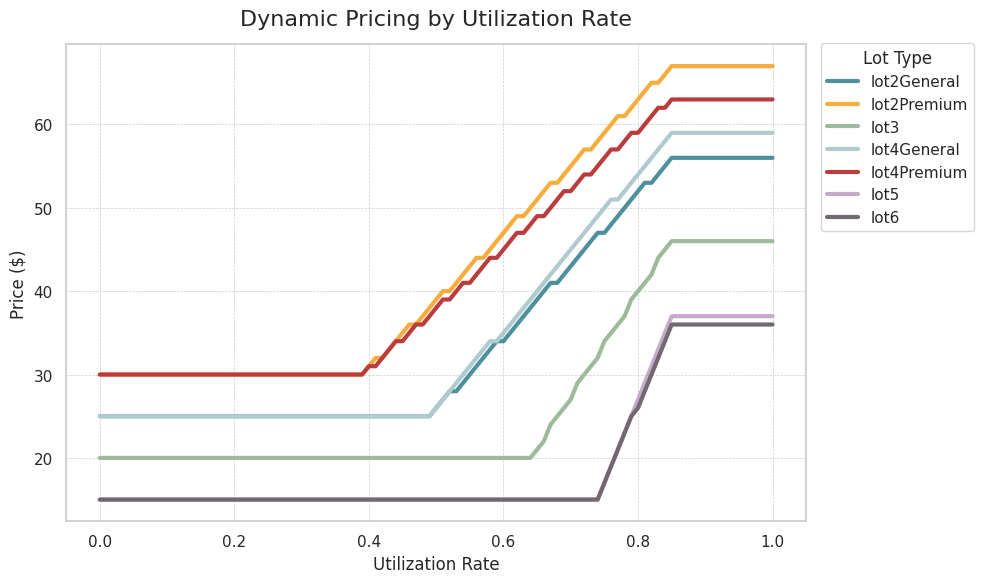

In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file
df = pd.read_csv("newDynamicPriceTable_lowered.csv")

# Set Seaborn style for a clean look
sns.set(style="whitegrid")

colors = {
    "lot2General": "#4e909e",
    "lot2Premium": "#f7ac3b",
    "lot3": "#9dba9a",
    "lot4General": "#b0cbce",
    "lot4Premium": "#ba3c3c",
    "lot5": "#c4acc9",
    "lot6": "#736871"
}



plt.figure(figsize=(10, 6))




for col in df.columns[1:]:
    plt.plot(
        df["UtilizationRate"],
        df[col],
        label=col,
        color=colors.get(col, "black"),
        linewidth=3
    )

plt.title("Dynamic Pricing by Utilization Rate", fontsize=16, pad=14)
plt.xlabel("Utilization Rate", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)
plt.legend(title="Lot Type", bbox_to_anchor=(1.01, 1.02), loc='upper left')
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()